In [189]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Getting the data 

In [173]:
trainset = pd.read_csv("../../Downloads/Predict_churn/train_v2.csv")

In [174]:
members = pd.read_csv("../../Downloads/Predict_churn/members_v2.csv")

In [175]:
samplesubmission = pd.read_csv("../../Downloads/Predict_churn/sample_submission_v2.csv")

## Basic info

In [176]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 2 columns):
msno        970960 non-null object
is_churn    970960 non-null int64
dtypes: int64(1), object(1)
memory usage: 14.8+ MB


In [177]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795090 entries, 0 to 795089
Data columns (total 6 columns):
msno                      795090 non-null object
city                      795090 non-null int64
bd                        795090 non-null int64
gender                    318249 non-null object
registered_via            795090 non-null int64
registration_init_time    795090 non-null int64
dtypes: int64(4), object(2)
memory usage: 36.4+ MB


In [178]:
members["registered_via"].value_counts()

7     475062
9     182871
3      86021
4      47686
13      3450
Name: registered_via, dtype: int64

In [179]:
members["city"].value_counts()

1     456706
13     78447
5      60295
4      40421
22     33051
15     31354
6      20500
14     15830
12      9891
9       7645
8       6426
11      6317
18      6204
10      5257
21      4467
3       4338
17      4299
7       2049
16       835
20       629
19       129
Name: city, dtype: int64

# Cleaning features

In [181]:
# Age between 10 - 90
members["bd"].where(members["bd"] > 10, 0, inplace=True)
members["bd"].where(members["bd"] < 90, 0, inplace=True)

# 0 values to Nan?

In [ ]:
# City - 1 seems to be the default that people select

In [185]:
# Parsing dates
members["registration_init_time"] = pd.to_datetime(members["registration_init_time"], format='%Y%m%d', errors='ignore')

In [195]:
# Making gender labels
le = preprocessing.LabelEncoder()
le.fit(members["gender"])
members["gender"]=le.transform(members["gender"])

In [193]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,duration_of_membership,gender2
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011-09-14,15230 days 23:59:59.999997,0
1,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,2011-09-15,15231 days 23:59:59.999997,1
2,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,13,63,male,9,2011-09-18,15234 days 23:59:59.999997,2
3,OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=,1,0,NaN,7,2011-09-18,15234 days 23:59:59.999997,0
4,4De1jAxNRABoyRBDZ82U0yEmzYkqeOugRGVNIf92Xb8=,4,28,female,9,2011-09-20,15236 days 23:59:59.999997,1


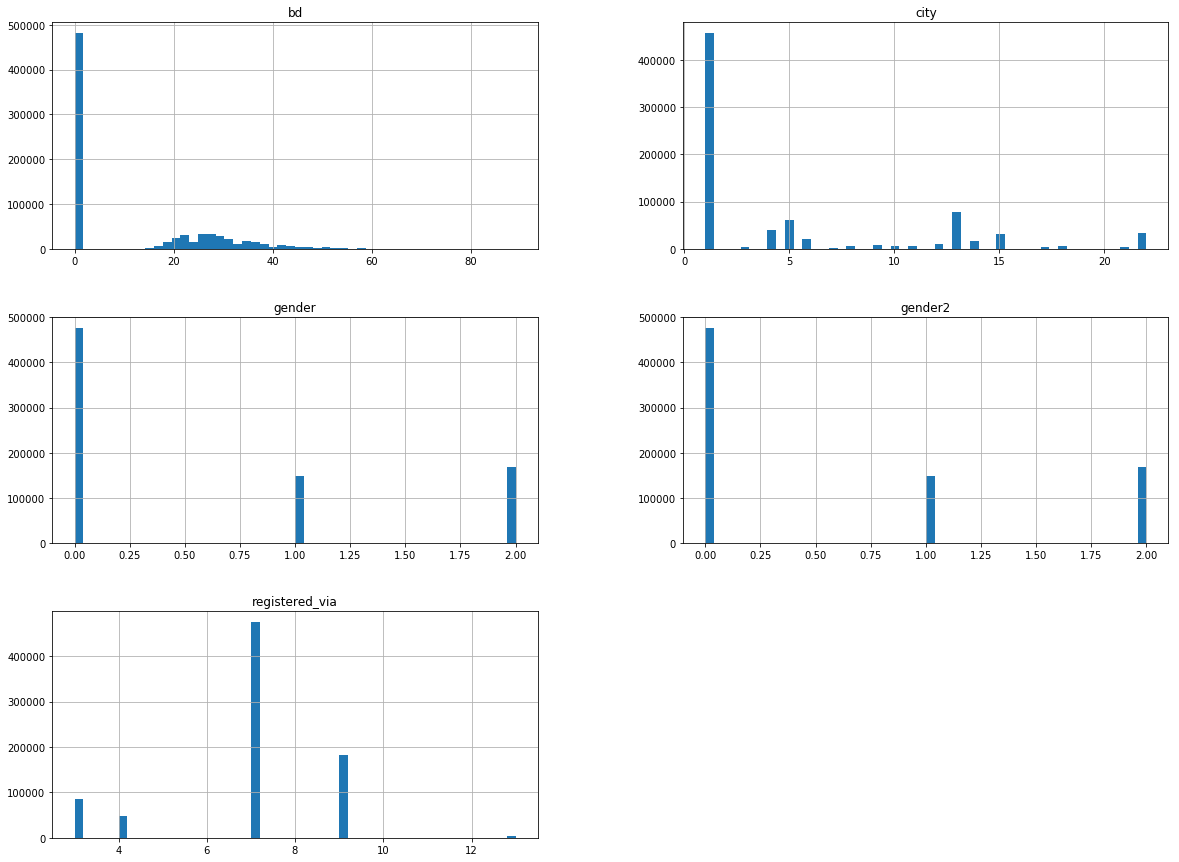

In [196]:
members.hist(bins=50, figsize=(20,15))
plt.show()

In [162]:
from collections import defaultdict

s=members["registration_init_time"]
d = defaultdict(int)

for k in s: 
    d[k] += 1
    
counts = d.items()

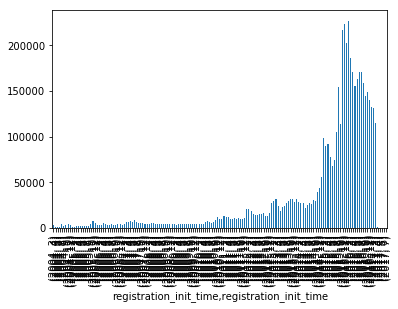

In [166]:
members["registration_init_time"].groupby([members["registration_init_time"].dt.year, members["registration_init_time"].dt.month]).count().plot(kind="bar")

# Creating new features

In [187]:
members["duration_of_membership"] = members["registration_init_time"]-pd.to_datetime(2017-04-01)

## Test filling sample submission with the churn numbers we have 

In [67]:
submission1 = pd.merge(samplesubmission, trainset, how='left', on="msno")

In [70]:
submission1=submission1[["msno", "is_churn_y"]]
submission1.columns=['msno', 'is_churn']

In [71]:
submission1= submission1.fillna(0)
submission1.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.0


In [75]:
submission1.to_csv("../../Downloads/Predict_churn/submission1.csv", header=True, index=False)

# Creating training data

In [92]:
members_train = pd.merge(trainset, members, how='inner', on="msno")

train_set, val_set = train_test_split(members_train, test_size=0.2, random_state=42)